In [1]:
import torch
import torchvision
import torchinfo
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from icecream import ic

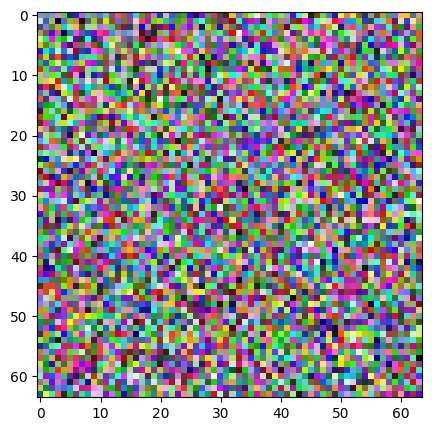

In [2]:
def imshow(img, figsize=(5, 5)):
    if isinstance(img, torch.Tensor):
        img = img.detach().numpy()

    if len(img.shape) == 4:
        img = img.squeeze(0)

    assert len(img.shape) == 3

    if img.shape[2] != 3:
        img = img.transpose(1, 2, 0)

    assert img.shape[2] == 3

    plt.figure(figsize=figsize)

    return plt.imshow(img)


testimage = np.random.randint(0,255, size = (1, 64, 64, 3))
imshow(testimage)

In [3]:
model = torchvision.models.resnet34(pretrained=True)

/Users/danesherburn/repos/feature-visualisation/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/danesherburn/repos/feature-visualisation/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [173]:
class Naivepixelparam(nn.Module):
    def __init__(self):
        super().__init__()
        self.img = nn.Parameter(torch.rand(1, 3, 224, 224))

    def forward(self):
        return torch.clip(self.img, min = 0, max = 1)


def optim_img(img: nn.Module, model: nn.Module, steps=1, logit=50, transforms=None, lr=0.05):
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)

    if transforms is None:
        transforms = lambda x: x

    for step in range(steps):
        optimizer.zero_grad()
        transformed = transforms(img())
        logits = model(transformed)
        loss = -logits[:, logit]  # [batch_size, class]
        loss.backward()
        optimizer.step()
    
    return img


transforms = torch.nn.Sequential(
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomAffine(degrees=10, translate=(0.05, 0.05))
)

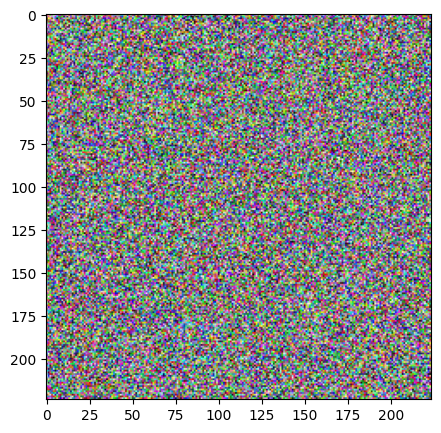

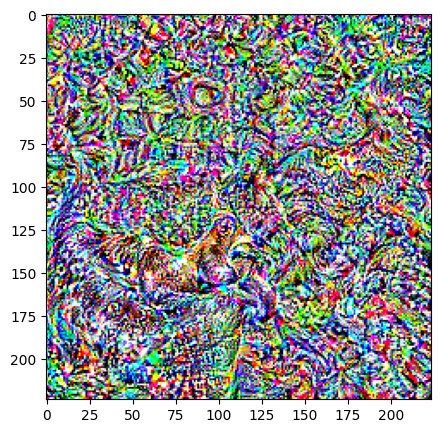

In [18]:
img_naive = Naivepixelparam()
imshow(img_naive())

img_naive = optim_img(img_naive, model, logit=150, steps=150, transforms=transforms)
imshow(img_naive())

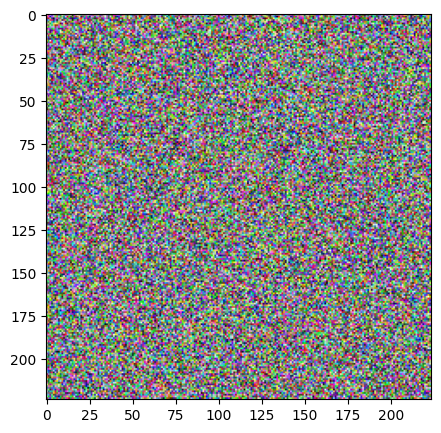

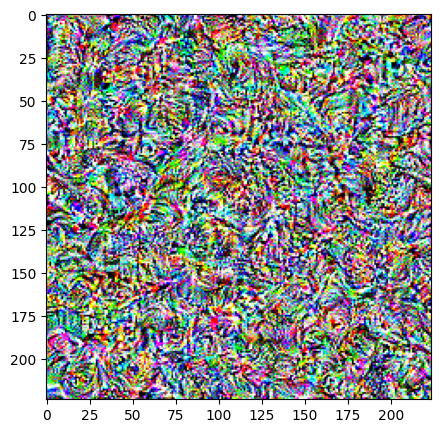

In [14]:
img_naive = Naivepixelparam()
imshow(img_naive())

img_naive = optim_img(img_naive, model, logit=150, steps=150, transforms=None)
imshow(img_naive())

In [65]:
class SigmoidPixelParam(nn.Module):
    def __init__(self):
        super().__init__()
        self.img = nn.Parameter(torch.randn(size=(1, 3, 224, 224)))

    def forward(self):
        return torch.sigmoid(self.img)

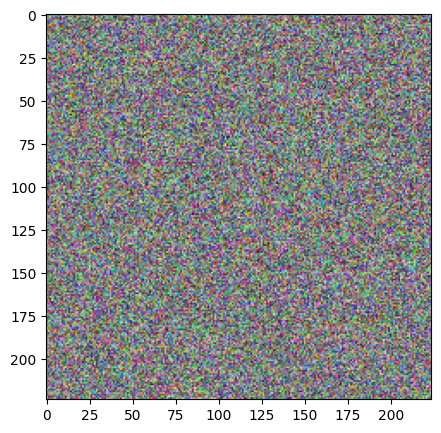

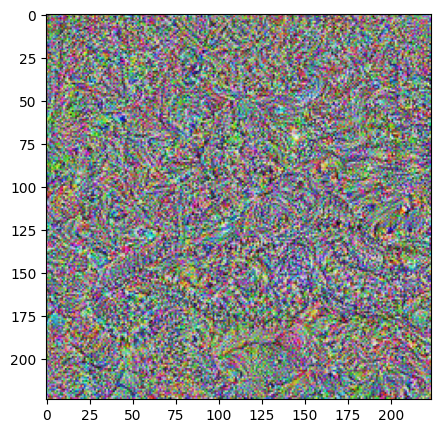

In [66]:
img_sigmoid = SigmoidPixelParam()
imshow(img_sigmoid())

img_sigmoid = optim_img(img_sigmoid, model, logit=50, steps=150, transforms=transforms)
imshow(img_sigmoid())

In [67]:
class FourierPixelParam(nn.Module):
    def __init__(self):
        super().__init__()
        self.freq_params = nn.Parameter(torch.randn(size=(1, 3, 224, 113, 2)))  # TODO: possibly x100

    def forward(self):
        img = torch.view_as_complex(self.freq_params)
        img = torch.fft.irfft2(img, norm="ortho", s=(224, 224))  # TODO: maybe include s=(height, width) to irfft2
        return torch.sigmoid(img)

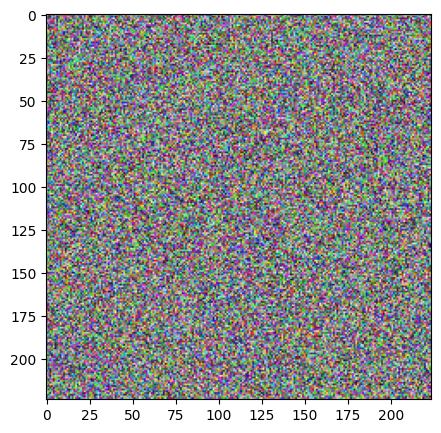

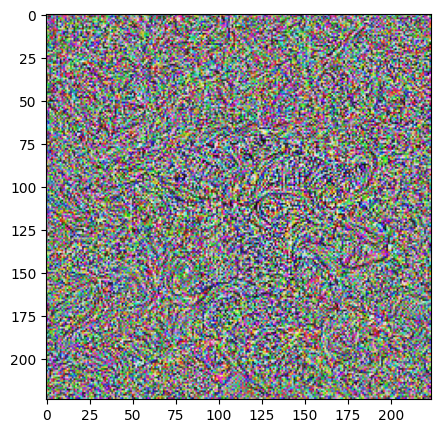

In [68]:
img_fourier = FourierPixelParam()
imshow(img_fourier())

img_fourier = optim_img(img_fourier, model, logit=50, steps=100, transforms=transforms)
imshow(img_fourier())

In [144]:
class TheirFourierPixelNormalisedParam(nn.Module):
    def __init__(self):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        H, W = self.freq.shape[2:4]
        freq_magnitude = (torch.fft.fftfreq(H)[:,None]**2 + torch.fft.fftfreq(W)**2).sqrt()
        freq_magnitude[0, 0] = 1/H
        self.register_buffer('freq_magnitude', freq_magnitude)
    
    def forward(self):
        image = torch.fft.irfft2(torch.view_as_complex(self.freq) / self.freq_magnitude)
        image = image + 0.5
        # return image.sigmoid()
        return torch.clip(image, min = 0, max = 1)

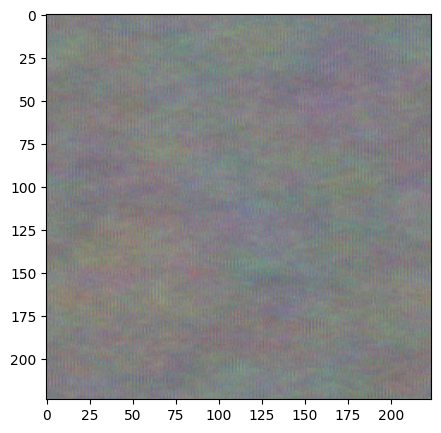

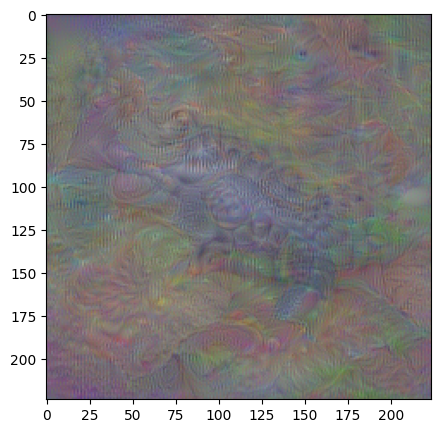

In [146]:
img_their_normalised_fourier = TheirFourierPixelNormalisedParam()
imshow(img_their_normalised_fourier())

img_their_normalised_fourier = optim_img(img_their_normalised_fourier, model, logit=50, steps=1_000, transforms=transforms)
imshow(img_their_normalised_fourier())

In [187]:
class FourierPixelNormalisedParam(nn.Module):
    def __init__(self):
        super().__init__()
        self.freq_params = nn.Parameter(torch.randn(size=(1, 3, 224, 113, 2)))  # TODO: possibly x100

        fx = torch.fft.fftfreq(113)
        fy = torch.fft.fftfreq(224)
        const = (fx**2 + fy[:, None]**2) ** 0.5
        const[0, 0] = 1.0 / 224
        self.register_buffer("normalisation_constant", const)
    
    def forward(self):
        img = torch.view_as_complex(self.freq_params)
        img = img / self.normalisation_constant
        img = torch.fft.irfft2(img, s=(224, 224))
        img = img * 20 + 0.5
        # return torch.sigmoid(img)
        return torch.clip(img, min = 0, max = 1)

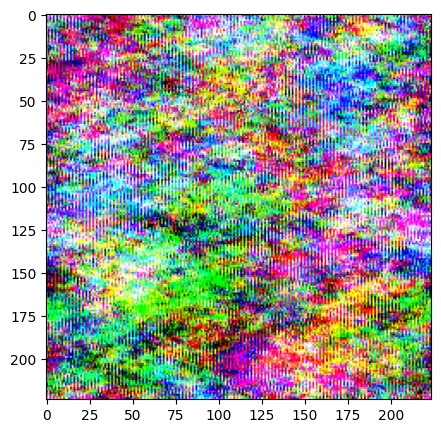

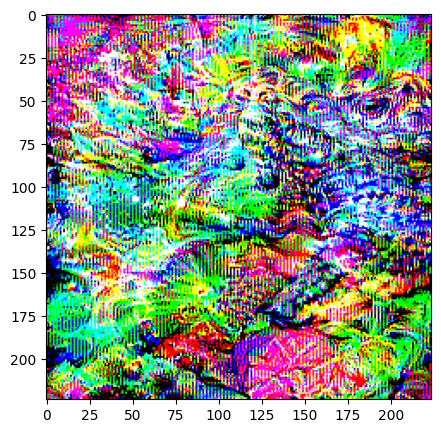

In [188]:
img_normalised_fourier = FourierPixelNormalisedParam()
imshow(img_normalised_fourier())

img_normalised_fourier = optim_img(img_normalised_fourier, model, logit=50, steps=1_000, transforms=transforms)
imshow(img_normalised_fourier())

In [185]:
class FourierPixelNormalisedDecorrelatedParam(nn.Module):
    def __init__(self):
        super().__init__()
        self.freq_params = nn.Parameter(torch.randn(size=(1, 3, 224, 113, 2)))

        projection = torch.tensor(
            [
                [ 0.56282854,  0.19482528,  0.0432945 ],
                [ 0.5844758,   0.,         -0.10823626],
                [ 0.5844758,  -0.19482528,  0.06494176],
            ]
        )
        # projection = torch.tensor(
        #     [
        #         [0.26, 0.09, 0.02 ],
        #         [0.27, 0.00, -0.05],
        #         [0.27, -0.09, 0.03],
        #      ]
        # )
        assert projection.shape == (3,3)
        self.register_buffer("projection", projection)

        fx = torch.fft.fftfreq(113)
        fy = torch.fft.fftfreq(224)
        const = (fx**2 + fy[:, None]**2) ** 0.5
        const[0, 0] = 1.0 / 224
        self.register_buffer("normalisation_constant", const)
    
    def forward(self):
        img = torch.view_as_complex(self.freq_params)
        img = img / self.normalisation_constant
        img = torch.fft.irfft2(img, s=(224, 224))
        img = torch.einsum("kc, bchw -> bkhw", self.projection, img)
        # img = torch.einsum("kc,bcij -> bkij", self.projection, img)
        img = img * 20 + 0.5
        return torch.clip(img, min=0.0, max=1.0)
        # return torch.sigmoid(img)

In [189]:
img_normalised_decorrelated_fourier = FourierPixelNormalisedDecorrelatedParam()
imshow(img_normalised_decorrelated_fourier())

img_normalised_decorrelated_fourier = optim_img(img_normalised_decorrelated_fourier, model, logit=71, steps=500, transforms=transforms, lr=0.1)
imshow(img_normalised_decorrelated_fourier())